In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import math

from mac0460_5832.utils import *

########################################################################
#
# OBS:
#
# A função draw_img original lia o atributo shape como uma tupla
# (width, height). Como é mais natural descrever o shape de uma matriz
# como (linhas = height, colunas = width), eu optei por modificar essa
# função para ler os vetores dessa maneira. Os resultados não devem se
# alterar, apenas virar.


########################################################################
#
# Classes                                                       
#
###
# WOperator Learner Class
class WOperatorLearner:
    """ Class used to learn a biniary image operator """
    
    def __init__ (self, n, m, mask=[]):
        """ Class constructor """
        self.window_shape = (n, m)
        self.samples = {}
        self._update_hypothesis ()
        self.mask = list (mask)
        if not self.mask:
            for i in range (n):
                self.mask.append ([])
                for j in range (m):
                    self.mask[i].append (1)
        self.mask = np.array (self.mask)

        
    def sample_image (self, src, dest):
        """ Samples an image, adding samples to the self.samples
        hash """
        x_offset = int ((self.window_shape[1] - 1) / 2)
        y_offset = int ((self.window_shape[0] - 1) / 2)
        bsrc = zero_border_img (src, x_offset, y_offset)
        window_configuration = []
        sy, ey = 0, 2 * y_offset + 1
        for i in range (src.shape[0]):
            sx, ex = 0, 2 * x_offset + 1
            for j in range (src.shape[1]):
                window = bsrc[sy:ey, sx:ex]
                window = np.multiply (window, self.mask)
                w_int = window_to_int (window, 2)
                label = dest[i][j]
                if (w_int not in self.samples):
                    self.samples[w_int] = [0, 0]
                self.samples[w_int][label] += 1
                sx += 1
                ex += 1
            sy += 1
            ey += 1
        self._update_hypothesis ()


    def get_hypothesis (self):
        ''' Returns a hash containing that represents the hypothesis '''
        return self.hypothesis


    def get_samples (self):
        ''' Returns samples hash '''
        return self.samples


    def _update_hypothesis (self):
        ''' Creates the hypothesis hash '''
        self.hypothesis = {}
        h = self.hypothesis
        n = self.window_shape[0]
        m = self.window_shape[1]
        for w in self.samples:
            l = self.samples[w][0] < self.samples[w][1]
            h[w] = l
    
    def clean_samples (self):
        ''' Cleans hash of samples and hypothesis '''
        self.samples = {}
        self._update_hypothesis ()
                
# End of WOperatorLearner Class
##           



###
# WOperator Classs
class WOperator:
    """ Class used to define a W-Operator """
    
    def __init__ (self, f, shape, mask = []):
        """ Class constructor. f should be an array of size
        2 ^ (window size) """
        self.f = f
        self.shape = shape
        self.mask = list (mask)
        if not self.mask:
            for i in range (shape[0]):
                self.mask.append ([])
                for j in range (shape[1]):
                    self.mask[i].append (1)
        self.mask = np.array (self.mask)
        

    def operate_image (self, img):
        """ Operates over an image """
        x_border = (self.shape[1] - 1) // 2
        y_border = (self.shape[0] - 1) // 2
        bimg = zero_border_img (img, x_border, y_border)
        dest = np.copy (img)
        sy, ey = 0, self.shape[0]
        for i in range (img.shape[0]):
            sx, ex = 0, self.shape[1]
            for j in range (img.shape[1]):
                window = bimg[sy:ey, sx:ex]
                window = np.multiply (window, self.mask)
                w_int = window_to_int (window, 2)
                if w_int in self.f:
                    dest[i][j] = self.f[w_int]
                else:
                    dest[i][j] = 0
                sx += 1
                ex += 1
            sy += 1
            ey += 1
        return dest
                
        

# End of WOperator Class
##



###
# Multiresolution WOperator Learner Class
#
class Multiresolution:
    """ Class used to learn a binary image operator using 
    Multiresolution. 
    
    We define the levels of the pyramid recursively:
    If a level has window size n, where n should be an odd number, then
    the following level will have window of size: 
    a) (n + 1) / 2 + 1, if n = 3 mod 4
    b) (n + 1) / 2,     if n = 1 mod 4 """
    
    def __init__ (self, n):
        """ Class constructor. This class implements Multiresolution 
        with a pyramid """
        m = n
        self.window_shape = (n, m)
        self.wol_list = []
        self.sample_list = []
        wol_size = m
        self.wol_list.append (WOperatorLearner (wol_size, wol_size))
        while (wol_size > 3):
            if (wol_size % 4 == 3):
                wol_size = (wol_size + 1) // 2 + 1
            else:
                wol_size = wol_size // 2 + 1
            self.wol_list.append (WOperatorLearner (wol_size, wol_size))
        self.wol_list.append (WOperatorLearner (3, 3))
        self.wol_list.append (WOperatorLearner (1, 1))
        self.lookup_table = {}
            
        
    
    def sample_image (self, src, dest):
        """ Samples an image, on each leavel of the multiresolution
        pyramid, and stores them at the sample_list array """
        self.sample_list = []
        for learner in self.wol_list:
            learner.sample_image (src, dest)
        self.sample_list = []
        for i in range (0, len (self.wol_list)):
            self.sample_list.append (self.wol_list[i].get_samples ())


    def get_samples (self):
        """ Returns an array that store the samples of each level of
        the pyramid """
        return self.sample_list

    
    def classify_window (self, window):
        """ Given a window, returns the label of that window, using the 
        multiresolution approach """
        w_int = window_to_int (window, 2)
        i = 0
        while (i < len (self.sample_list)):
            samples = self.sample_list[i]
            if (w_int in samples):
                answ = samples[w_int][0] < samples[w_int][1]
                return answ
            else:
                window = Multiresolution.remap_up (window)
                w_int = window_to_int (window, 2)
            i += 1
        return False
    
    
    def operate_image (self, img):
        """ Operates over an image """
        x_border = (self.window_shape[1] - 1) // 2
        y_border = (self.window_shape[0] - 1) // 2
        bimg = zero_border_img (img, x_border, y_border)
        dest = np.copy (img)
        sy, ey = 0, self.window_shape[0]
        for i in range (img.shape[0]):
            sx, ex = 0, self.window_shape[1]
            for j in range (img.shape[1]):
                window = bimg[sy:ey, sx:ex]
                y = self.classify_window (window)
                dest[i][j] = y
                sx += 1
                ex += 1
            sy += 1
            ey += 1
        return dest

        
    @staticmethod
    def remap_up (window):
        """ Maps a window to a smaller dimension on the pyramid of
        multiresolution. We map a window n x n to another of size
        m x m where m is:
        a) (n + 1) / 2 + 1, if n = 3 mod 4
        b) (n + 1) / 2,     if n = 1 mod 4
        
        The mapping occurs selecting every other line and column of
        the original window. In the case a) we also add every other
        element of the column and row in the middle, otherwise the 
        new window would have an even number of rows and and columns
        """
        n = window.shape[0]
        new_window = []
        if (n % 4 == 3):
            m = (n + 1) // 2 + 1
            new_window = np.zeros ((m, m))
            # every other line and column
            for i in range (0, n, 2):
                for j in range (0, n, 2):
                    nw_i = i // 2
                    nw_j = j // 2
                    if i > n // 2:
                        nw_i += 1
                    if j > n // 2:
                        nw_j += 1
                    new_window[nw_i][nw_j] = window[i][j]
            # middle line and collumn
            for i in range (0, n, 2):
                nw_i = i // 2 
                if i > n // 2:
                    nw_i += 1
                new_window[nw_i][m // 2] = window[i][n // 2]
            for j in range (0, n, 2):
                nw_j = j // 2
                if j > n // 2:
                    nw_j += 1
                new_window[m // 2][nw_j] = window[n // 2][j]
            new_window[m // 2][m // 2] = window[n // 2][n // 2]
        else:
            m = (n + 1) // 2
            new_window = np.zeros ((m, m))
            # every other line and column
            for i in range (0, n, 2):
                for j in range (0, n, 2):
                    nw_i = i // 2
                    nw_j = j // 2
                    new_window[nw_i][nw_j] = window[i][j]
        return new_window
    
    
    def clean_samples (self):
        self.samples = {}
        self._update_hypothesis ()
        
# End of Multiresolution Class
##


###
# Multiresolution Envelope WOperator Learner Class
#
class MultiresolutionEnvelope (Multiresolution):
    """ Class used to learn a binary image operator using 
    Multiresolution and using envelope. """
    
    def __init__ (self, n):
        """ Class constructor. This class implements Multiresolution 
        with a pyramid """
        Multiresolution.__init__ (self, n)

            
    def classify_window (self, window):
        """ Given a window, returns the label of that window, using the 
        multiresolution approach """
        w_int = window_to_int (window, 2)
        i = 0
        while (i < len (self.sample_list)):
            samples = self.sample_list[i]
            if (w_int in samples):
                # psi_rho (x) = | 0, if betha (rho (x)) = 0
                #               | 1, if alpha (rho (x)) = 1
                #               | psi (x) otherwise
                rho_x = self.remap_up (window)
                se_size = rho_x.shape[0] // 2
                alpha_w = self.alpha_rho (rho_x, se_size)
                betha_w = self.betha_rho (rho_x, se_size)
                mid = alpha_w.shape[0] // 2
                if (alpha_w[mid, mid] == 1):   # alpha (rho (x)) = 1
                    return True
                if (betha_w[mid, mid] == 0):   # betha (rho (x)) = 0
                    return False
                return samples[w_int][0] < samples[w_int][1]
            else:
                window = Multiresolution.remap_up (window)
                w_int = window_to_int (window, 2)
            i += 1
        return False
    

    def alpha_rho (self, img, se_size):
        se = se_box (se_size)
        o = opening (img, se)
        return o
    
    
    def betha_rho (self, img, se_size):
        se = se_box (se_size)
        c = closing (img, se)
        return c
    
# End of Multiresolution Class
##



########################################################################
#
# General Use Functions                                                   
#
###
def window_to_int (window, base):
    """ Maps a window to an integer. The way this function works is
    reading the window as a number of base <base> from left to right
    and up to down. It returns the same number in base 10 """
    total = 0
    power = 1
    w = window.tolist ()
    for row in w:
        for element in row:
            total += element * power
            power *= base
    return int (total)


def int_to_window (number, base, shape):
    """ The inverse of window_to_int """
    power = 1
    window_size = shape[0] * shape[1]
    w_arr = []
    while (number > 0):
        d = number % base
        number = number // base
        w_arr.append (d)
    while (len (w_arr) < window_size):
        w_arr.append (0)
    w = np.array ([w_arr])
    w.reshape (shape)
    return w


def zero_border_img (img, x_border, y_border):
    """ This function creates a border of zeros on img """
    h = img.shape[0]
    w = img.shape[1]
    new_h = h + 2 * y_border
    new_w = w + 2 * x_border
    zeros = np.zeros ((new_h, new_w))
    bordered_img = zeros
    y_start, y_end = y_border, -y_border
    x_start, x_end = x_border, -x_border
    if y_border is 0: y_end = h
    if x_border is 0: x_end = w
    bordered_img[y_start:y_end, x_start:x_end] += img
    return bordered_img


def abs_img_error (img1, img2):
    ''' Calculates absolute error of two binary images '''
    img_shape = img1.shape
    e = 0.0
    for i in range (img_shape[0]):
        for j in range (img_shape[1]):
            e += int (img1[i][j] != img2[i][j])
    return e


def wop_err (wop, src_list, dest_list):
    """ Calculates the error of a W-Operator """
    rel_err = 0.0
    img_shape = src_list[0].shape
    for i, img in enumerate (src_list):
        res = wop.operate_image (img)
        rel_err += abs_img_error (dest_list[i], res)
    rel_err /= (img_shape[0] * img_shape[1] * len (src_list))
    return rel_err

# MAC0460/5832 - Lista 1: Aprendizado de W-Operadores

### Data de Entrega: 23h55m do dia 05/05/2017



Q1. Encontre, utilizando a técnica de aprendizado de w-operadores vista em sala, o operador 1x3 (1 linha, 3 colunas) capaz de transformar a imagem src1 em dest1 (veja as variáveis abaixo) mostrando a tabela de padrões encontrada. Teste seu operador na imagem src1 e verifique que ele funciona como esperado. Teste seu operador nas imagens images/q1/1_test1.png e images/q1/1_test2.png desenhando as imagens obtidas (sugestão: use a função draw_img do arquivo mac0460_5832/utils.py).

---------- Pattern table ---------
[[0, 0, 0]] zeros = 26, uns = 0
[[0, 0, 1]] zeros = 5, uns = 0
[[0, 1, 0]] zeros = 0, uns = 2
[[1, 0, 0]] zeros = 5, uns = 0
[[0, 1, 1]] zeros = 0, uns = 3
[[1, 1, 1]] zeros = 5, uns = 0
[[1, 1, 0]] zeros = 0, uns = 3


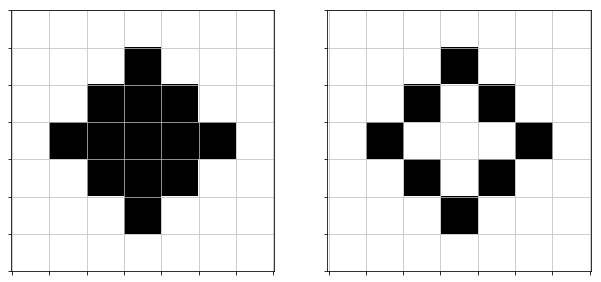

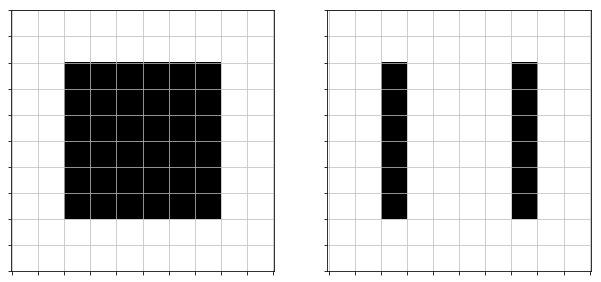

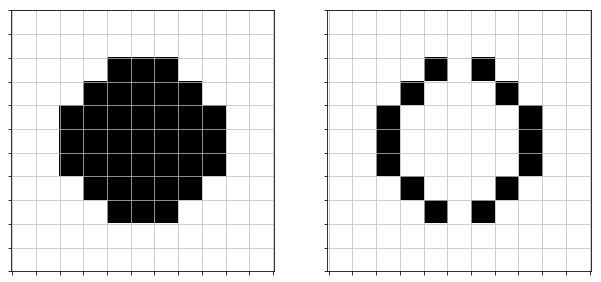

In [3]:
########################################################################
src1 = read_img('images/q1/1_src.png')
dest1 = read_img('images/q1/1_dest.png')
test1_1 = read_img('images/q1/1_test1.png')
test1_2 = read_img('images/q1/1_test2.png')

# Learns patter from src1, dest1
# draw_img_pair(src1, dest1)
wopl = WOperatorLearner (1, 3)
w_shape = (1, 3)
wopl.sample_image (src1, dest1)

# Prints pattern table
print ('---------- Pattern table ---------')
table = wopl.get_samples ()
for key in table:
    w = int_to_window (key, 2, w_shape)
    print (w.tolist (), end=' ')
    print ('zeros = ' + str (table[key][0]) + ', uns = ' + 
           str (table[key][1]))

#  Creates W-Operator
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape)

# Transform src1
res1 = wop.operate_image (src1)
draw_img_pair(src1, res1)

# Tests same operator on test1_1 and tes1_2
draw_img_pair (test1_1, wop.operate_image (test1_1))
draw_img_pair (test1_2, wop.operate_image (test1_2))

Q2. Aprenda o operador 3x3 para detecção de bordas. Treine seu operador nas imagens da pastas images/q2/ usando os pares (q2_src\*.png, q2_dest\*.png). Teste seu operador nas imagens images/q2/q2_test.png e images/q2/q2_test2.png. Algumas das imagens de treino são desenhadas abaixo.

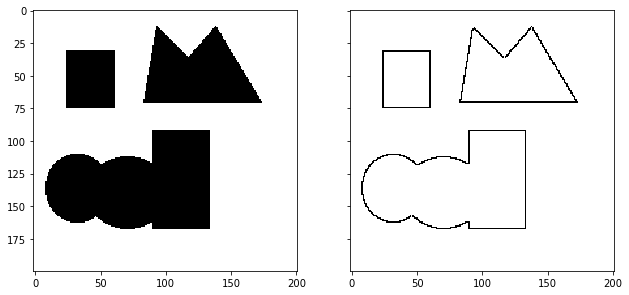

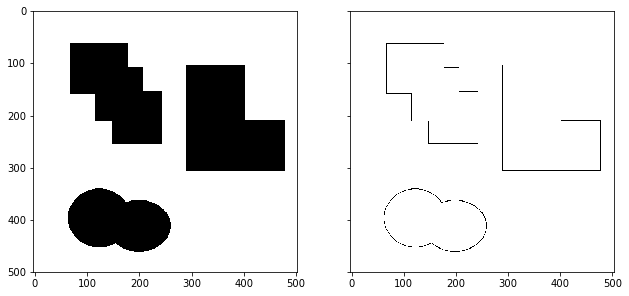

In [5]:
########################################################################
src2_1 = read_img('images/q2/q2_src1.png')
src2_2 = read_img('images/q2/q2_src2.png')
src2_3 = read_img('images/q2/q2_src3.png')
src2_4 = read_img('images/q2/q2_src4.png')
src2_5 = read_img('images/q2/q2_src5.png')
dest2_1 = read_img('images/q2/q2_dest1.png')
dest2_2 = read_img('images/q2/q2_dest2.png')
dest2_3 = read_img('images/q2/q2_dest3.png')
dest2_4 = read_img('images/q2/q2_dest4.png')
dest2_5 = read_img('images/q2/q2_dest5.png')
q2_test = read_img ('images/q2/q2_test.png')
q2_test2 = read_img ('images/q2/q2_test2.png')

# Learns patter from src*, dest*
wopl = WOperatorLearner (3, 3)
w_shape = (3, 3)
wopl.sample_image (src2_1, dest2_1)
wopl.sample_image (src2_2, dest2_2)
wopl.sample_image (src2_3, dest2_3)
wopl.sample_image (src2_4, dest2_4)
wopl.sample_image (src2_5, dest2_5)

# Creates W-Operator
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape)

# Transform q2_test and q2_test2
res1 = wop.operate_image (q2_test)
res2 = wop.operate_image (q2_test2)
draw_img_pair(q2_test, res1)
draw_img_pair(q2_test2, res2)

Q3. Use o algoritmo de aprendizado para obter um operador capaz de eliminar ruído. Use no treinamento as imagens images/q3/q3_src\*.png sempre com o mesmo target images/q3/q3_dest.png. Teste a janela com 5 elementos (cruz). Teste seu operador nas imagens images/q3/q3_test1.png e images/q3/q3_test2.png. Calcule e plote os erros $E_{in}$ e $E_{out}$ obtidos durante o treinamento.

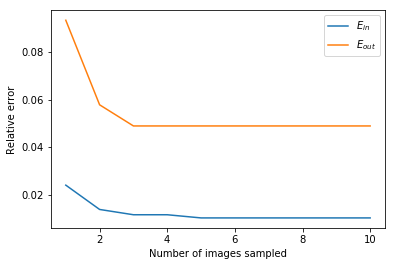

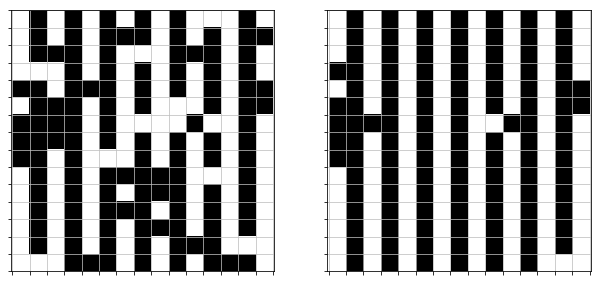

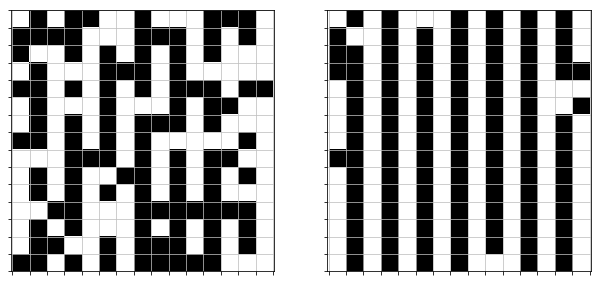

In [6]:
########################################################################
src3_1 = read_img ('images/q3/q3_src1.png')
src3_2 = read_img ('images/q3/q3_src2.png')
src3_3 = read_img ('images/q3/q3_src3.png')
src3_4 = read_img ('images/q3/q3_src4.png')
src3_5 = read_img ('images/q3/q3_src5.png')
src3_6 = read_img ('images/q3/q3_src6.png')
src3_7 = read_img ('images/q3/q3_src7.png')
src3_8 = read_img ('images/q3/q3_src8.png')
src3_9 = read_img ('images/q3/q3_src9.png')
src3_10 = read_img ('images/q3/q3_src10.png')
dest3 = read_img ('images/q3/q3_dest.png')
q3_test1 = read_img ('images/q3/q3_test1.png')
q3_test2 = read_img ('images/q3/q3_test2.png')

e_in_arr = []
e_out_arr = []

# Learns patter from src*, dest* and builds e_in and e_out arrays
mask = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]
wopl = WOperatorLearner (3, 3, mask)
w_shape = (3, 3)

src_list = (src3_1, src3_2, src3_3, src3_4, src3_5, src3_6, src3_7,
            src3_8, src3_9, src3_10)
test_list = (q3_test1, q3_test2)
dest_list = (dest3, dest3, dest3, dest3, dest3, dest3, dest3, dest3,
            dest3, dest3)

## Sample 1
wopl.sample_image (src3_1, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 2
wopl.sample_image (src3_2, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 3
wopl.sample_image (src3_3, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 4
wopl.sample_image (src3_4, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 5
wopl.sample_image (src3_5, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 6
wopl.sample_image (src3_6, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 7
wopl.sample_image (src3_7, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 8
wopl.sample_image (src3_8, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 9
wopl.sample_image (src3_9, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 10
wopl.sample_image (src3_10, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

# Plots E_in and E_out
ax = plt.gca ()
x = range (1, 11)
plt.plot (x, e_in_arr, label = '$E_{in}$')
plt.plot (x, e_out_arr, label = '$E_{out}$')
handlers, labels = ax.get_legend_handles_labels ()
ax.legend (handlers, labels, loc = 'upper right', numpoints = 1)
plt.ylabel ('Relative error')
plt.xlabel ('Number of images sampled')
plt.show ()

# Transform q2_test and q2_test2
res1 = wop.operate_image (q3_test1)
res2 = wop.operate_image (q3_test2)
# Tests operator
draw_img_pair(q3_test1, res1)
draw_img_pair(q3_test2, res2)

Q4. Projete um operador para aprender a extrair a letra 's' de imagens de texto. Para isso utilize os pares de imagens q4_src\*.png q4_dest\*.png da pasta images/q4/train. Teste seu operador nas imagens da pasta images/q4/test. Utilize a composição de janelas pequenas. Avalie o erro do seu operador comparando a saída obtida por ele com a saída esperada (imagens q4_gt\*.png da pasta images/q4/test).

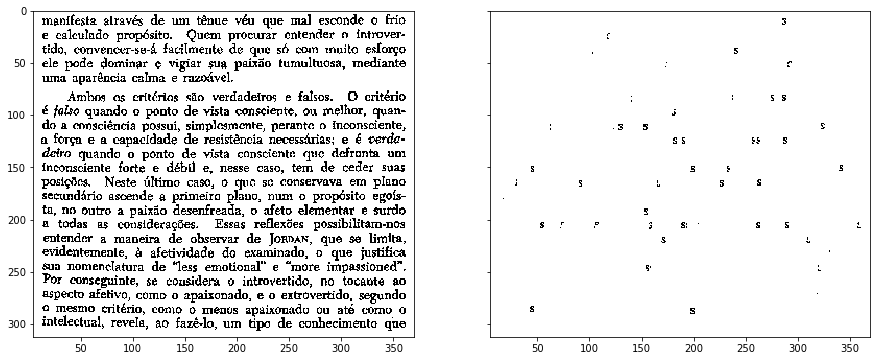

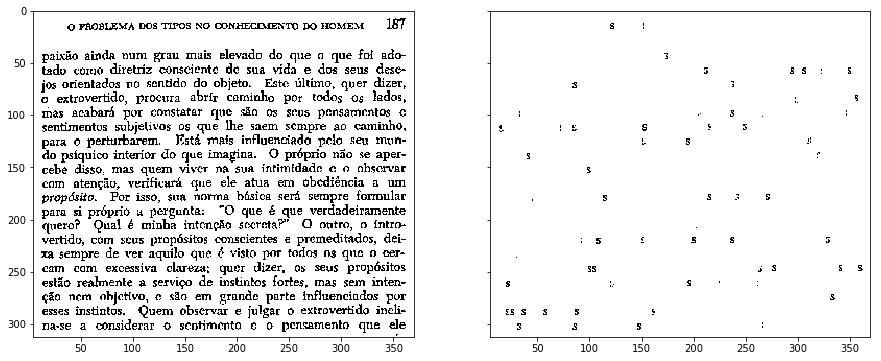

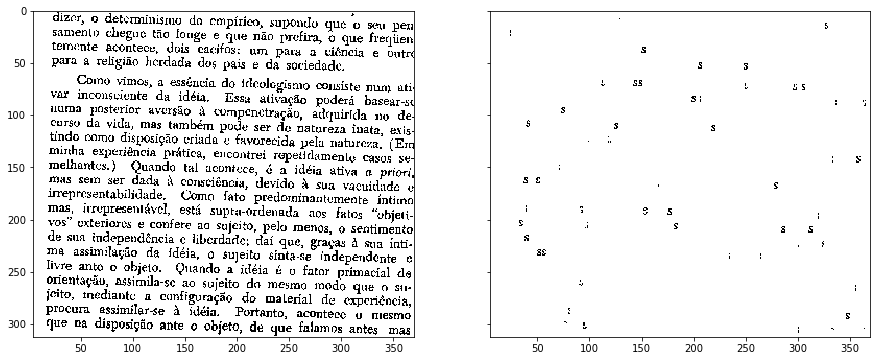

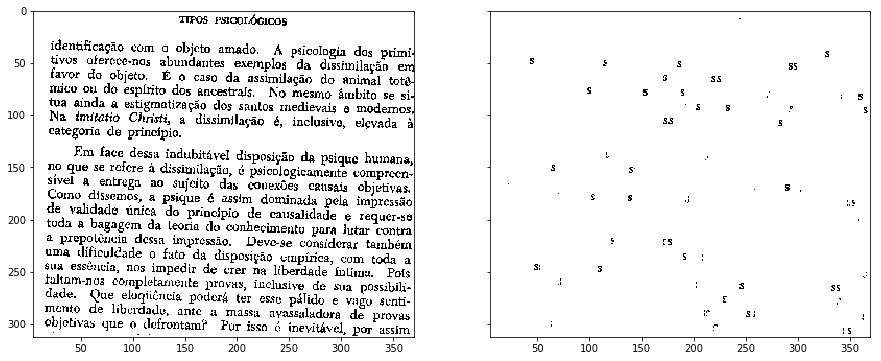

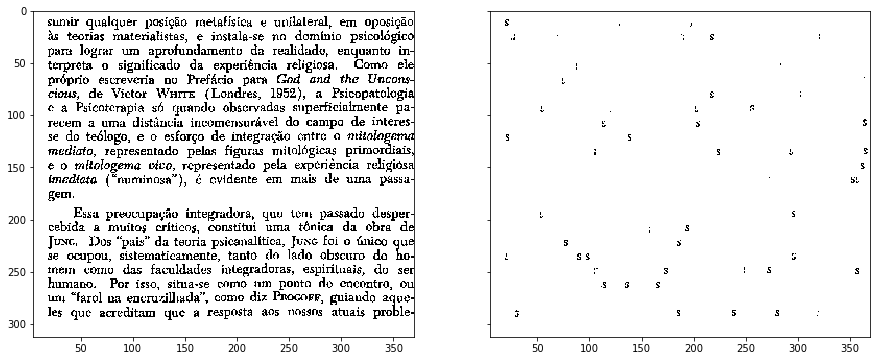

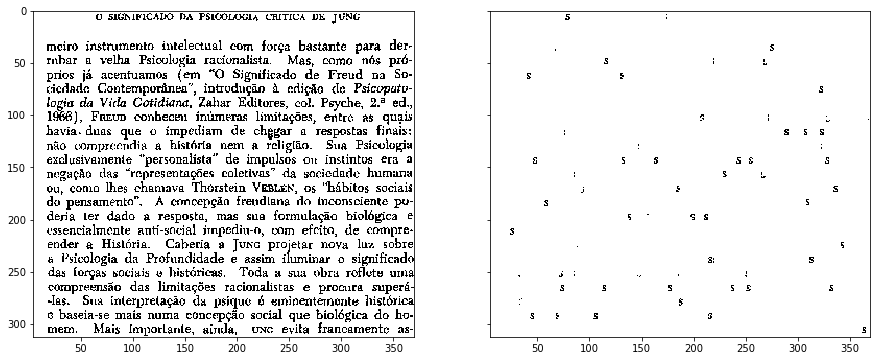

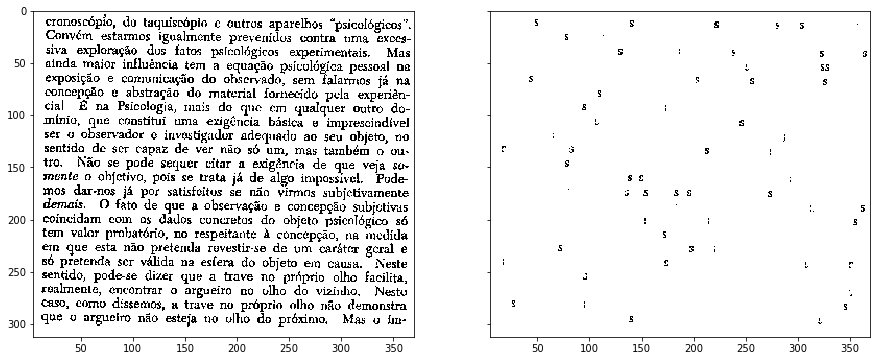

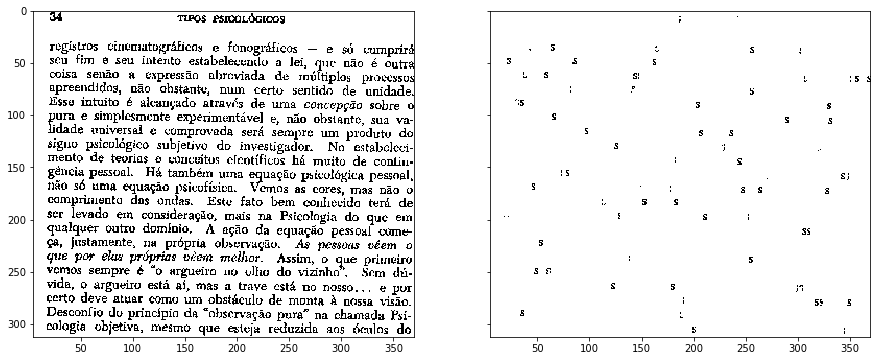

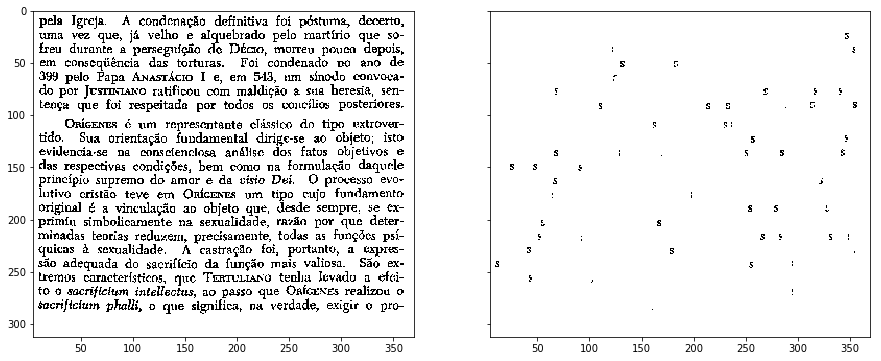

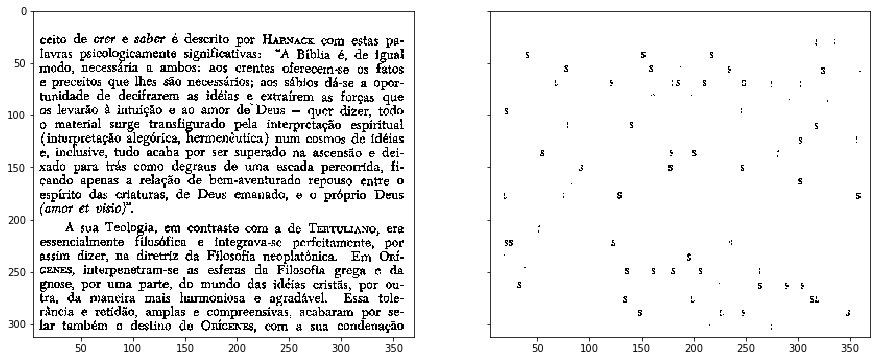

E_out = 0.005217465388711395


In [7]:
w_shape = (7, 3)
wopla = WOperatorLearner (7, 3)
woplb = WOperatorLearner (7, 3)

# Training Set a
src4_1a = read_img ("images/q4/train/q4_src1a.png")
dest4_1a = read_img ("images/q4/train/q4_dest1a.png")
wopla.sample_image (src4_1a, dest4_1a)
del src4_1a
del dest4_1a
src4_3a = read_img ("images/q4/train/q4_src3a.png")
dest4_3a = read_img ("images/q4/train/q4_dest3a.png")
wopla.sample_image (src4_3a, dest4_3a)
del src4_3a
del dest4_3a
src4_5a = read_img ("images/q4/train/q4_src5a.png")
dest4_5a = read_img ("images/q4/train/q4_dest5a.png")
wopla.sample_image (src4_5a, dest4_5a)
del src4_5a
del dest4_5a
src4_7a = read_img ("images/q4/train/q4_src7a.png")
dest4_7a = read_img ("images/q4/train/q4_dest7a.png")
wopla.sample_image (src4_7a, dest4_7a)
del src4_7a
del dest4_7a
src4_9a = read_img ("images/q4/train/q4_src9a.png")
dest4_9a = read_img ("images/q4/train/q4_dest9a.png")
wopla.sample_image (src4_9a, dest4_9a)
del src4_9a
del dest4_9a

# Training Set b
src4_1b = read_img ("images/q4/train/q4_src1b.png")
dest4_1b = read_img ("images/q4/train/q4_dest1b.png")
woplb.sample_image (src4_1b, dest4_1b)
del src4_1b
del dest4_1b
src4_3b = read_img ("images/q4/train/q4_src3b.png")
dest4_3b = read_img ("images/q4/train/q4_dest3b.png")
woplb.sample_image (src4_3b, dest4_3b)
del src4_3b
del dest4_3b
src4_5b = read_img ("images/q4/train/q4_src5b.png")
dest4_5b = read_img ("images/q4/train/q4_dest5b.png")
woplb.sample_image (src4_5b, dest4_5b)
del src4_5b
del dest4_5b
src4_7b = read_img ("images/q4/train/q4_src7b.png")
dest4_7b = read_img ("images/q4/train/q4_dest7b.png")
woplb.sample_image (src4_7b, dest4_7b)
del src4_7b
del dest4_7b
src4_9b = read_img ("images/q4/train/q4_src9b.png")
dest4_9b = read_img ("images/q4/train/q4_dest9b.png")
woplb.sample_image (src4_9b, dest4_9b)
del src4_9b
del dest4_9b

ha = wopla.get_hypothesis ()
hb = woplb.get_hypothesis ()
wopa = WOperator (ha, w_shape)
wopb = WOperator (hb, w_shape)

# Test Set
test4_2b = read_img ("images/q4/test/q4_test2b.png")
test4_2a = read_img ("images/q4/test/q54_test2a.png")
test4_4b = read_img ("images/q4/test/q4_test4b.png")
test4_4a = read_img ("images/q4/test/q4_test4a.png")
test4_6b = read_img ("images/q4/test/q4_test6b.png")
test4_6a = read_img ("images/q4/test/q4_test6a.png")
test4_8b = read_img ("images/q4/test/q4_test8b.png")
test4_8a = read_img ("images/q4/test/q4_test8a.png")
test4_10b = read_img ("images/q4/test/q4_test10b.png")
test4_10a = read_img ("images/q4/test/q4_test10a.png")

dest4_2b = read_img ("images/q4/test/q4_gt2b.png")
dest4_2a = read_img ("images/q4/test/q4_gt2a.png")
dest4_4b = read_img ("images/q4/test/q4_gt4b.png")
dest4_4a = read_img ("images/q4/test/q4_gt4a.png")
dest4_6b = read_img ("images/q4/test/q4_gt6b.png")
dest4_6a = read_img ("images/q4/test/q4_gt6a.png")
dest4_8b = read_img ("images/q4/test/q4_gt8b.png")
dest4_8a = read_img ("images/q4/test/q4_gt8a.png")
dest4_10b = read_img ("images/q4/test/q4_gt10b.png")
dest4_10a = read_img ("images/q4/test/q4_gt10a.png")
test_list = (test4_2b, test4_2a, test4_4b, test4_4a, test4_6b,
             test4_6a, test4_8b, test4_8a, test4_10b, test4_10a)
dest_list = (dest4_2b, dest4_2a
             , dest4_4b, dest4_4a, dest4_6b,
             dest4_6a, dest4_8b, dest4_8a, dest4_10b, dest4_10a) 

error = 0.0
for i, img in enumerate (test_list):
    answ = wopa.operate_image (img)
    answ = wopb.operate_image (answ)
    draw_img_pair (img, answ, figsz=(15, 6))
    del img
    dest = dest_list[i]
    error += abs_img_error (dest_list[i], answ)
    del dest
error /= (test_list[0].shape[0] * test_list[0].shape[1] *
          len (test_list))
print ('E_out = ' + str (error))

Q5. Utilizando a técnica de multiresolução, aprenda o operador capaz de remover ruído das imagens da pasta images/q5/. Utilize os pares de imagens (q5_src\*.png, q5_dest.png) para o treinamento e depois teste seu  operador nas imagens q5_test1.png e q5_test2.png.

Sampled image 1
Sampled image 2
Sampled image 3
Sampled image 4
Sampled image 5
Sampled image 6
Sampled image 7
Sampled image 8
Sampled image 9
Sampled image 10


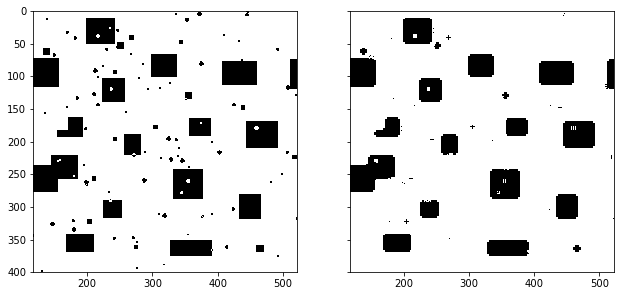

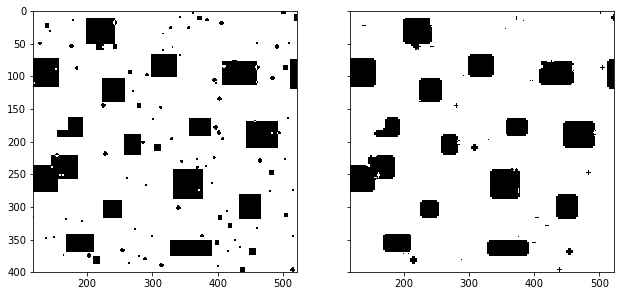

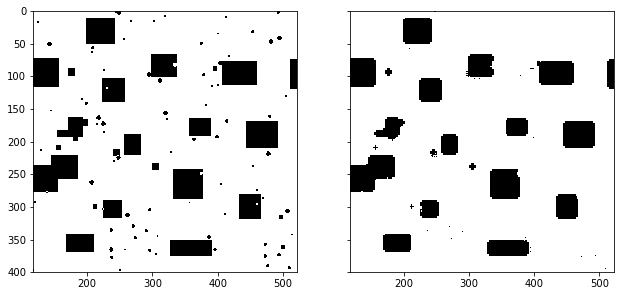

In [8]:
dest5 = read_img ("images/q5/q5_dest.png")
src5_1 = read_img ("images/q5/q5_src1.png")
src5_2 = read_img ("images/q5/q5_src2.png")
src5_3 = read_img ("images/q5/q5_src3.png")
src5_4 = read_img ("images/q5/q5_src4.png")
src5_5 = read_img ("images/q5/q5_src5.png")
src5_6 = read_img ("images/q5/q5_src6.png")
src5_7 = read_img ("images/q5/q5_src7.png")
src5_8 = read_img ("images/q5/q5_src8.png")
src5_9 = read_img ("images/q5/q5_src9.png")
src5_10 = read_img ("images/q5/q5_src10.png")
q5test1 = read_img ("images/q5/q5_test1.png")
q5test2 = read_img ("images/q5/q5_test2.png")
q5test3 = read_img ("images/q5/q5_test3.png")

multi_op = Multiresolution (7)
multi_op.sample_image (src5_1, dest5)
print ("Sampled image 1")
del src5_1
multi_op.sample_image (src5_2, dest5)
print ("Sampled image 2")
del src5_2
multi_op.sample_image (src5_3, dest5)
print ("Sampled image 3")
del src5_3
multi_op.sample_image (src5_4, dest5)
print ("Sampled image 4")
del src5_4
multi_op.sample_image (src5_5, dest5)
print ("Sampled image 5")
del src5_5
multi_op.sample_image (src5_6, dest5)
print ("Sampled image 6")
del src5_6
multi_op.sample_image (src5_7, dest5)
print ("Sampled image 7")
del src5_7
multi_op.sample_image (src5_8, dest5)
print ("Sampled image 8")
del src5_8
multi_op.sample_image (src5_9, dest5)
print ("Sampled image 9")
del src5_9
multi_op.sample_image (src5_10, dest5)
print ("Sampled image 10")
del src5_10

res1 = multi_op.operate_image (q5test1)
draw_img_pair (q5test1, res1)
res2 = multi_op.operate_image (q5test2)
draw_img_pair (q5test2, res2)
res3 = multi_op.operate_image (q5test3)
draw_img_pair (q5test3, res3)
# draw_img (src5_1)
# draw_img (src5_2)

Q6. Utilize a técnica de envelope, como visto em sala, para remover ruído de imagens. Use o mesmo dataset da questão anterior e as funções de morfologia disponíveis em mac0460_5832/utils.py para definir as funções $\alpha$ e $\beta$. Um exemplo de erosão em uma das imagens de treino é mostrado abaixo. Comente sobre a escolha das funções $\alpha$ e $\beta$.

Lets consider an image: 


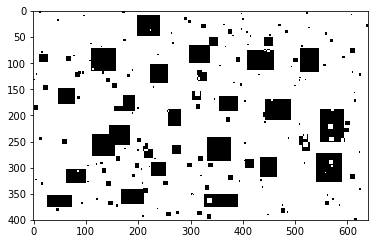

A opening operator alpha is able to remove most of the black noise and keeps the proportions of our elements


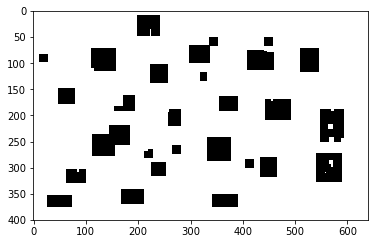

A closing operator betha is able to remove most of the white noise and keeps the propostions of our elements


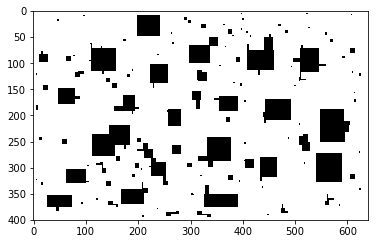

Sampled image 1
Sampled image 2
Sampled image 3
Sampled image 4
Sampled image 5
Sampled image 6
Sampled image 7
Sampled image 8
Sampled image 9
Sampled image 10


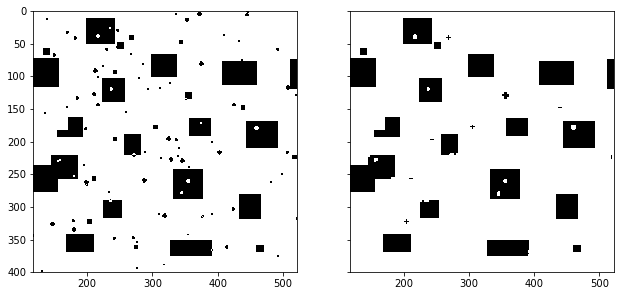

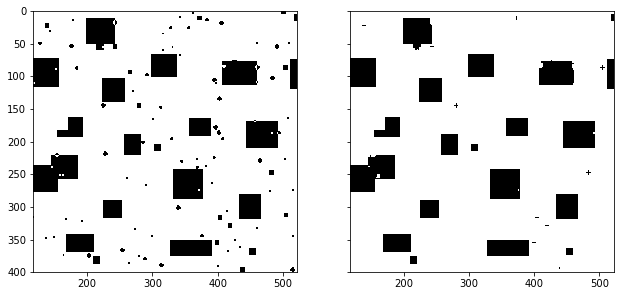

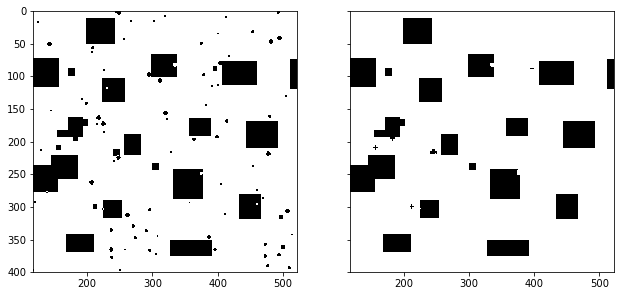

In [5]:
########################################################################
def my_opening (img):
    return opening (img, se_box (5))
    
def my_closing (img):
    return closing (img, se_box (5))

dest6 = read_img ("images/q5/q5_dest.png")
src6_1 = read_img ("images/q5/q5_src1.png")
src6_2 = read_img ("images/q5/q5_src2.png")
src6_3 = read_img ("images/q5/q5_src3.png")
src6_4 = read_img ("images/q5/q5_src4.png")
src6_5 = read_img ("images/q5/q5_src5.png")
src6_6 = read_img ("images/q5/q5_src6.png")
src6_7 = read_img ("images/q5/q5_src7.png")
src6_8 = read_img ("images/q5/q5_src8.png")
src6_9 = read_img ("images/q5/q5_src9.png")
src6_10 = read_img ("images/q5/q5_src10.png")
q6test1 = read_img ("images/q5/q5_test1.png")
q6test2 = read_img ("images/q5/q5_test2.png")
q6test3 = read_img ("images/q5/q5_test3.png")
print ("Lets consider an image: ")
draw_img (src6_1)
print ("A opening operator alpha is able to remove most of the"
    + " black noise and keeps the proportions of our elements")
draw_img (my_opening (src6_1))
print ("A closing operator betha is able to remove most of the"
    + " white noise and keeps the propostions of our elements")
draw_img (my_closing (src6_1))

# Samples images
wopl = WOperatorLearner (7, 7)
w_shape = (7, 7)
wopl.sample_image (src6_1, dest6)
print ("Sampled image 1")
del src6_1
wopl.sample_image (src6_2, dest6)
print ("Sampled image 2")
del src6_2
wopl.sample_image (src6_3, dest6)
print ("Sampled image 3")
del src6_3
wopl.sample_image (src6_4, dest6)
print ("Sampled image 4")
del src6_4
wopl.sample_image (src6_5, dest6)
print ("Sampled image 5")
del src6_5
wopl.sample_image (src6_6, dest6)
print ("Sampled image 6")
del src6_6
wopl.sample_image (src6_7, dest6)
print ("Sampled image 7")
del src6_7
wopl.sample_image (src6_8, dest6)
print ("Sampled image 8")
del src6_8
wopl.sample_image (src6_9, dest6)
print ("Sampled image 9")
del src6_9
wopl.sample_image (src6_10, dest6)
print ("Sampled image 10")
del src6_10


# Creates W-Operator psi
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape)


# Operate on test images with envelope of alpha and betha
psi = wop.operate_image (q6test1)
alpha = my_opening (q6test1)
betha = my_closing (q6test1)
res1 = np.multiply (betha, alpha + psi)
draw_img_pair (q6test1, res1)

psi = wop.operate_image (q6test2)
alpha = my_opening (q6test2)
betha = my_closing (q6test2)
res2 = np.multiply (betha, alpha + psi)
draw_img_pair (q6test2, res2)

psi = wop.operate_image (q6test3)
alpha = my_opening (q6test3)
betha = my_closing (q6test3)
res3 = np.multiply (betha, alpha + psi)
draw_img_pair (q6test3, res3)

### Q7. Utilize a técnica de envelope com multiresolução para aprender um operador capaz de remover ruído de imagens. Para cada uma das janelas, defina funções $\alpha$ e $\beta$ (podem ser diferentes). Compare o resultado obtido aplicando a mistura de técnicas com os resultados das duas questões anteriores.

Sampled image 1
Sampled image 2
Sampled image 3
Sampled image 4
Sampled image 5
Sampled image 6
Sampled image 7
Sampled image 8
Sampled image 9
Sampled image 10


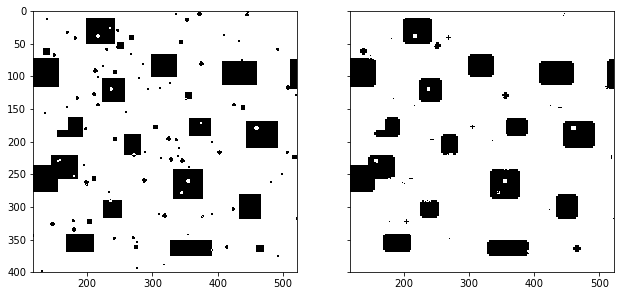

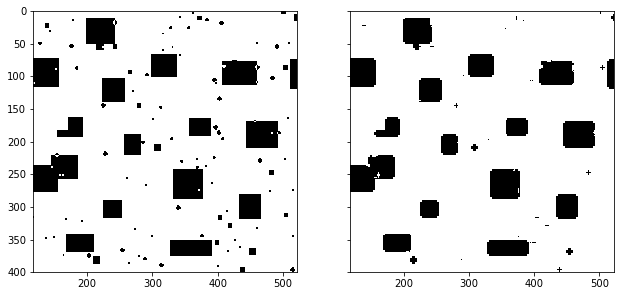

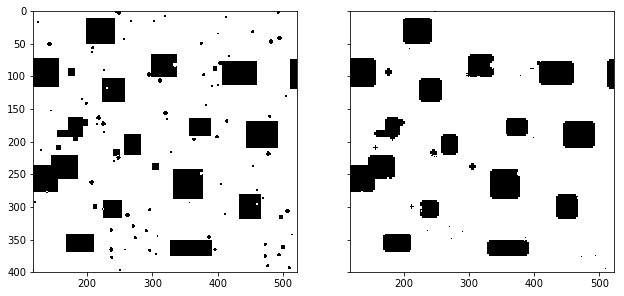

In [6]:
dest7 = read_img ("images/q5/q5_dest.png")
src7_1 = read_img ("images/q5/q5_src1.png")
src7_2 = read_img ("images/q5/q5_src2.png")
src7_3 = read_img ("images/q5/q5_src3.png")
src7_4 = read_img ("images/q5/q5_src4.png")
src7_5 = read_img ("images/q5/q5_src5.png")
src7_6 = read_img ("images/q5/q5_src6.png")
src7_7 = read_img ("images/q5/q5_src7.png")
src7_8 = read_img ("images/q5/q5_src8.png")
src7_9 = read_img ("images/q5/q5_src9.png")
src7_10 = read_img ("images/q5/q5_src10.png")
q7test1 = read_img ("images/q5/q5_test1.png")
q7test2 = read_img ("images/q5/q5_test2.png")
q7test3 = read_img ("images/q5/q5_test3.png")

# Samples images
multi_env = MultiresolutionEnvelope (7)
multi_env.sample_image (src7_1, dest7)
print ("Sampled image 1")
del src7_1
multi_env.sample_image (src7_2, dest7)
print ("Sampled image 2")
del src7_2
# multi_env.sample_image (src7_3, dest7)
print ("Sampled image 3")
del src7_3
multi_env.sample_image (src7_4, dest7)
print ("Sampled image 4")
del src7_4
multi_env.sample_image (src7_5, dest7)
print ("Sampled image 5")
del src7_5
multi_env.sample_image (src7_6, dest7)
print ("Sampled image 6")
del src7_6
multi_env.sample_image (src7_7, dest7)
print ("Sampled image 7")
del src7_7
multi_env.sample_image (src7_8, dest7)
print ("Sampled image 8")
del src7_8
multi_env.sample_image (src7_9, dest7)
print ("Sampled image 9")
del src7_9
multi_env.sample_image (src7_10, dest7)
print ("Sampled image 10")
del src7_10

# Operate on test images with envelope of alpha and betha
res1 = multi_env.operate_image (q7test1)
draw_img_pair (q7test1, res1)

res2 = multi_env.operate_image (q7test2)
draw_img_pair (q7test2, res2)

res3 = multi_env.operate_image (q7test3)
draw_img_pair (q7test3, res3)

Q8. A função gen_rand_imgs abaixo retorna um par de imagens. A primeira contém alguns pontos gerados aleatoriamente. A segunda é a dilatação da primeira por um elemento estruturante em forma de cruz. Aprenda o operador capaz de realizar essa transformação, gerando os pares de src e dest. Crie os dados de treinamento baseado na equação vista em sala ($m(\epsilon, \delta, H) = \frac{1}{\epsilon}ln\frac{|H|}{\delta}$). Compare o resultado obtido pelo seu classificador (gere mais pares para teste e ter uma estimativa de $E_{out}$) para $\epsilon = [0.2, 0.1]$ e $\delta = [0.3, 0.2]$.

For eps = 0.2 and delta = 0.3, a sample of size 117 was used, producing E_out = 0.0. An example of this operator: 


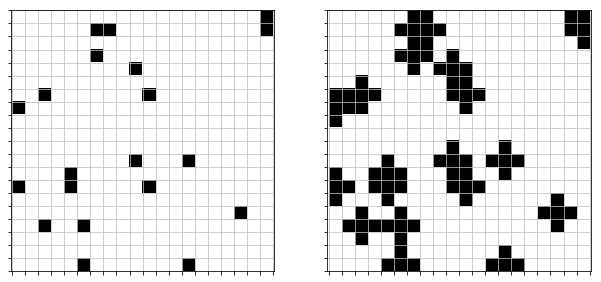

For eps = 0.1 and delta = 0.3, a sample of size 234 was used, producing E_out = 0.0. An example of this operator: 


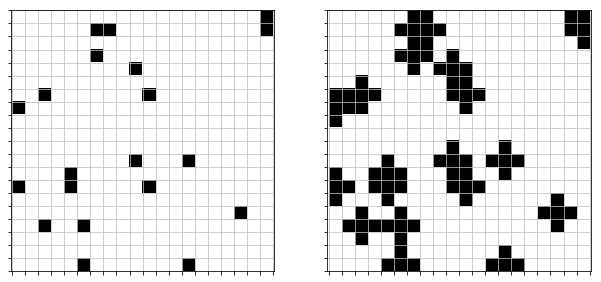

For eps = 0.2 and delta = 0.2, a sample of size 119 was used, producing E_out = 0.0. An example of this operator: 


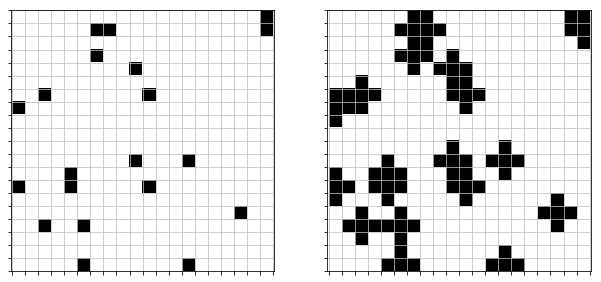

For eps = 0.1 and delta = 0.2, a sample of size 238 was used, producing E_out = 0.0. An example of this operator: 


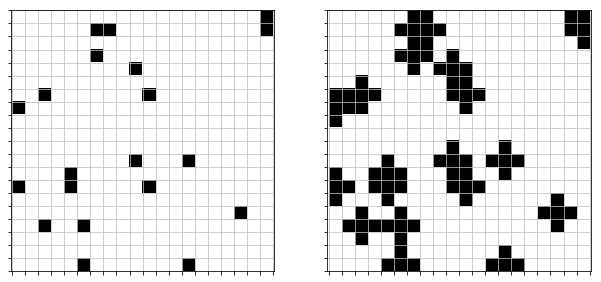

In [20]:
def gen_rand_imgs():
    n = 20
    noise = np.zeros((n, n)).astype(bool)
    num_pixels = n
    x = np.random.randint(0, n, num_pixels)
    y = np.random.randint(0, n, num_pixels)
    
    for i in range(num_pixels):
        noise[x[i], y[i]] = 1

    return noise, dilation(noise, se_cross(1))



# Test set
test_list = []
dest_list = []
for i in range (100):
    a, b = gen_rand_imgs ()
    dest_list.append (b)
    test_list.append (a)
# Just an image used to see the operator in action
example_img = gen_rand_imgs ()[0]


# For this problem we are going to use a 3x3 window
# with a cross-shaped mask, which means that the hypothesis
# function will be defined over the space of boolean functions
# of 5 variables. Therefore, for our calculations, the space of
# hypothesis has size 2^(2^5).
H_size = 2 ** (2 ** 5)


# Woperator Learner used
mask = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]
w_shape = (3, 3)
wopl = WOperatorLearner (3, 3, mask)

## When eps = 0.2 and delta = 0.3
eps = 0.2
delta = 0.3
m = int ((1.0 / eps) * math.log (H_size * (1 / delta)) + 1)
for i in range (m):
    src, dest = gen_rand_imgs ()
    wopl.sample_image (src, dest)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_out = wop_err (wop, test_list, dest_list)
print ('For eps = ' + str (eps) + ' and delta = ' + str (delta) + 
       ', a sample of size ' + str (m) + ' was used, producing' +
       ' E_out = ' + str (e_out) + '. An example of this operator: ')
draw_img_pair (example_img, wop.operate_image (example_img))

wopl.clean_samples ()

## When eps = 0.1 and delta = 0.3
eps = 0.1
delta = 0.3
m = int ((1.0 / eps) * math.log (H_size * (1 / delta)) + 1)
for i in range (m):
    src, dest = gen_rand_imgs ()
    wopl.sample_image (src, dest)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_out = wop_err (wop, test_list, dest_list)
print ('For eps = ' + str (eps) + ' and delta = ' + str (delta) + 
       ', a sample of size ' + str (m) + ' was used, producing' +
       ' E_out = ' + str (e_out) + '. An example of this operator: ')
draw_img_pair (example_img, wop.operate_image (example_img))

wopl.clean_samples ()

## When eps = 0.2 and delta = 0.2
eps = 0.2
delta = 0.2
m = int ((1.0 / eps) * math.log (H_size * (1 / delta)) + 1)
for i in range (m):
    src, dest = gen_rand_imgs ()
    wopl.sample_image (src, dest)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_out = wop_err (wop, test_list, dest_list)
print ('For eps = ' + str (eps) + ' and delta = ' + str (delta) + 
       ', a sample of size ' + str (m) + ' was used, producing' +
       ' E_out = ' + str (e_out) + '. An example of this operator: ')
draw_img_pair (example_img, wop.operate_image (example_img))

wopl.clean_samples ()

# When eps = 0.1 and delta = 0.2
eps = 0.1
delta = 0.2
m = int ((1.0 / eps) * math.log (H_size * (1 / delta)) + 1)
for i in range (m):
    src, dest = gen_rand_imgs ()
    wopl.sample_image (src, dest)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_out = wop_err (wop, test_list, dest_list)
print ('For eps = ' + str (eps) + ' and delta = ' + str (delta) + 
       ', a sample of size ' + str (m) + ' was used, producing' +
       ' E_out = ' + str (e_out) + '. An example of this operator: ')
draw_img_pair (example_img, wop.operate_image (example_img))